In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.utils import resample

#Franke Function analysis

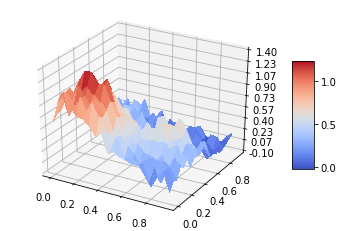

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')


# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


sigma=1
z = FrankeFunction(x, y)+sigma*np.random.normal(0, 0.1, x.shape)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


##OLS fit (no split, no scaling, no resampling)

Mean squared error: 0.035
Variance score: 0.293
Mean squared error: 0.027
Variance score: 0.546
Mean squared error: 0.016
Variance score: 0.659
Mean squared error: 0.013
Variance score: 0.737
Mean squared error: 0.011
Variance score: 0.798
Mean squared error: 0.010
Variance score: 0.806
Mean squared error: 0.009
Variance score: 0.820
Mean squared error: 0.009
Variance score: 0.835
Mean squared error: 0.008
Variance score: 0.850


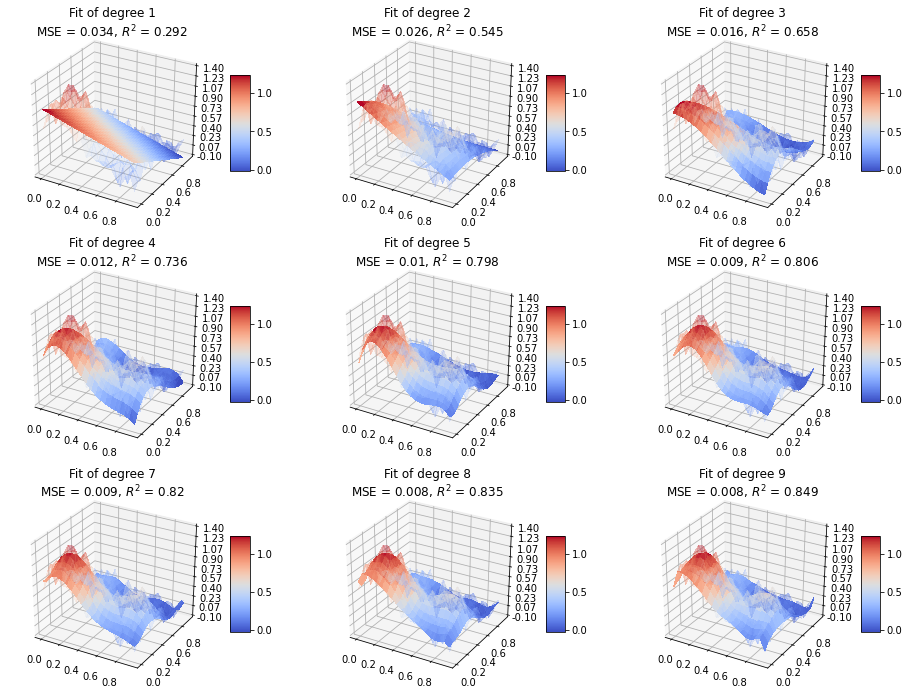

In [3]:

#Making a function that computes the design matrix and the ordinary least square regression

def design_matrix(x,y,z,degree):
    x = np.ravel(x)
    y = np.ravel(y)
    z = np.ravel(z)
    vals = np.concatenate(([x],[y]), axis=0).T
    poly = PolynomialFeatures(degree) # argument: polynomial degree
    X = poly.fit_transform(vals) # Fit to data, then transform it. 
    return X

def OLS(X,z):
    z = np.ravel(z)
    beta = np.linalg.inv(X.T @ X) @ X.T @ z
    return X@beta, beta 
  
def numOfDecimals(N,n):
  return int(N*(10**n))/(10**n)

fig = plt.figure(figsize= (16,12))
#fig,axes = plt.subplots( )# , projection = '3d')
maxDegree = 10
for p in range(1,maxDegree):
  #print(int(np.ceil((maxDegree)/3)),p//3,p%2)
  ax = fig.add_subplot(3, int(np.ceil((maxDegree-1)/3)), p, projection='3d')
  # Defining the degree of our fit 
  
  degree = p

  #Calling our functions and saving the results

  X = design_matrix(x,y,z,degree)

  z_pred, beta = OLS(X,z)
  MSE = mean_squared_error(z, z_pred.reshape(20,20))
  R2 = r2_score(z, z_pred.reshape(20,20))
  #Plotting the prediction

  ax = fig.gca(projection='3d')

  ax.plot_surface(x, y, z_pred.reshape(20,20), cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

  ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False, alpha = 0.2)

  # Customize the z axis.
  ax.set_zlim(-0.10, 1.40)
  ax.zaxis.set_major_locator(LinearLocator(10))
  ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
  ax.set_title('Fit of degree {}\nMSE = {}, $R^2$ = {}'.format(p,
                                         numOfDecimals(MSE,3),
                                         numOfDecimals(R2,3)))
  fig.colorbar(surf, shrink=0.5, aspect=5)
  # Add a color bar which maps values to colors.
  

  #plt.show()

  # The mean squared error                               
  print("Mean squared error: %.3f" % mean_squared_error(z, z_pred.reshape(20,20)))
  print('Variance score: %.3f' % r2_score(z, z_pred.reshape(20,20)))






##Test-train analysis

In [4]:
#Let's now define a function that scales and splits our data into test and train

def ScaleAndSplit(X,z):
    z = np.ravel(z)
    # splitting in training and test data
    X_train, X_test, z_train, z_test = train_test_split(X,z,test_size=0.2)
    # scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train) #Notice that we are using the train data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #Since we still want the first column of the design matrix to be just 1's even after scaling, then
    X_train_scaled[:,0]=1 
    X_test_scaled[:,0]=1
    #Calculating the fit 
    beta = np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train
    ztilde = X_train_scaled@beta
    zpredict = X_test_scaled@beta 
    return mean_squared_error(z_train,ztilde), mean_squared_error(z_test,zpredict) 


#Note: If you would fit the scaler using x_test you would be using information from your test set 
#and would be leaking data. This is information that you would not have if your model was in 
#production and can therefore not use when fitting your model.

print("MSE before scaling:%.5f" % mean_squared_error(z, z_pred.reshape(20,20)))

print("MSE after scaling: %.5f" % ScaleAndSplit(X,z)[1])

print('\n')

print('Scaling the data allows us to ignore data points that are very different from the rest (like measurement errors). These odd data points are also called outliers')


MSE before scaling:0.00818
MSE after scaling: 0.01583


Scaling the data allows us to ignore data points that are very different from the rest (like measurement errors). These odd data points are also called outliers


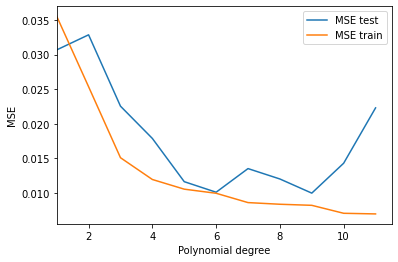

In [5]:
#Let's compute the model for different polinomial degrees

max_degree = 11


MSE_train = np.zeros(max_degree)
MSE_test = np.zeros(max_degree)
    
    
for degree in range(max_degree):
    X = design_matrix(x,y,z,degree+1)
    MSE_train[degree], MSE_test[degree] = ScaleAndSplit(X,z)
    
    
fig, ax = plt.subplots()
ax.set_xlabel('Polynomial degree')
ax.set_ylabel('MSE')
ax.plot(np.arange(max_degree)+1, MSE_test,label='MSE test')
ax.plot(np.arange(max_degree)+1, MSE_train,label='MSE train')
plt.xlim(xmin=1)
ax.legend()
plt.show()

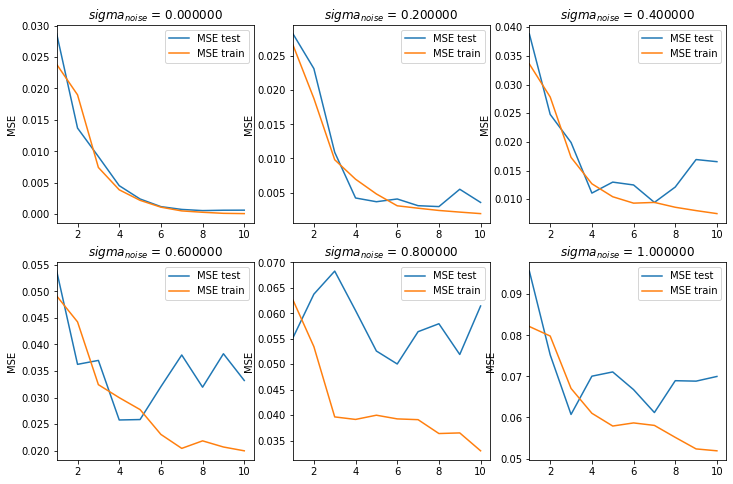

In [6]:
fig = plt.figure(figsize=(12,8))
for i in range(6):
  z_n = FrankeFunction(x, y)+0.5*i*np.random.normal(0, 0.1, x.shape,)
  var_e = np.std(0.5*i*np.random.normal(0, 0.1, x.shape))
  max_degree = 10


  MSE_train = np.zeros(max_degree)
  MSE_test = np.zeros(max_degree)
      
      
  for degree in range(max_degree):
      X = design_matrix(x,y,z_n,degree+1)
      MSE_train[degree], MSE_test[degree] = ScaleAndSplit(X,z_n)
      
      
  plt.subplot(2,3,i+1)
  #plt.xlabel('Polinomial degree')
  plt.ylabel('MSE')
  plt.title('$sigma_{noise}$ = %f' % (numOfDecimals(0.2*i,2)))#print "Found %d files" % (numFiles, )
  #plt.hlines(var_e**0.5,1,max_degree, ls = 'dashed')
  plt.plot(np.arange(max_degree)+1, MSE_test,label='MSE test')
  plt.plot(np.arange(max_degree)+1, MSE_train,label='MSE train')
  plt.xlim(xmin=1)
  plt.legend()
  #plt.show()

##Bias-variance tradeoff

Polynomial degree: 1
Polynomial degree: 2
Polynomial degree: 3
Polynomial degree: 4
Polynomial degree: 5
Polynomial degree: 6
Polynomial degree: 7
Polynomial degree: 8
Polynomial degree: 9
Polynomial degree: 10


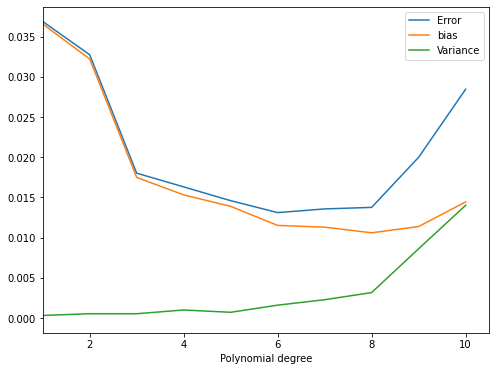

Optimal model found in the min value of the MSE, where the variance grows and the bias decreases. Beyond that we are overfitting so our predicting capability is deteriorating


One can show that the true expected value of a data set is obtained with an infinite number of resamplings


FALTA CALCULAR LA DEPENDENCIA RESPECTO AL NÚMERO DE DATOS Y EL RUIDO


In [7]:
# Make data
z = np.ravel(z)



n_boostraps = 100
maxdegree=11


error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

betas = []
for degree in range(1,maxdegree):
    betas.append([])
    X = design_matrix(x,y,z,degree)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    # scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #Since we still want the first column of the design matrix to be just 1's even after scaling, then
    X_train_scaled[:,0]=1 
    X_test_scaled[:,0]=1
    
    # The following (80 x n_bootstraps) matrix holds the column vectors z_pred
    # for each bootstrap iteration.  
    z_pred = np.empty((z_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        X_, z_ = resample(X_train_scaled, z_train)
        #Calculating the fit 
        beta = np.linalg.inv(X_.T @ X_) @ X_.T @ z_
        betas[degree-1].append(beta)
        z_pred[:, i] = X_test_scaled@beta 
        
# Note: Expectations and variances taken w.r.t. different training
# data sets, hence the axis=1. Subsequent means are taken across the test data
# set in order to obtain a total value, but before this we have error/bias/variance
# calculated per data point in the test set.
# Note 2: The use of keepdims=True is important in the calculation of bias as this 
# maintains the column vector form. Dropping this yields very unexpected results.
    
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((z_test.reshape(z_test.shape[0],1) - z_pred)**2, axis=1, keepdims = True) )
    bias[degree] = np.mean( (z_test.reshape(z_test.shape[0],1) - np.mean(z_pred, axis=1, keepdims = True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims = True) )
    print('Polynomial degree:', degree)

fig = plt.figure(figsize=(8,6))   
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Polynomial degree')
plt.xlim(xmin=1)
plt.legend()
plt.show()





print('Optimal model found in the min value of the MSE, where the variance grows and the bias decreases. Beyond that we are overfitting so our predicting capability is deteriorating')



print('\n')

print('One can show that the true expected value of a data set is obtained with an infinite number of resamplings')

print('\n')
print('FALTA CALCULAR LA DEPENDENCIA RESPECTO AL NÚMERO DE DATOS Y EL RUIDO')


##Cross-validation

For 5 folds, the MSE obtained is: 0.0866 ± 0.0987
For 6 folds, the MSE obtained is: 0.0415 ± 0.0396
For 7 folds, the MSE obtained is: 0.0304 ± 0.0336
For 8 folds, the MSE obtained is: 0.0165 ± 0.0076
For 9 folds, the MSE obtained is: 0.0178 ± 0.0110
For 10 folds, the MSE obtained is: 0.0168 ± 0.0104
For 11 folds, the MSE obtained is: 0.0148 ± 0.0097
For 12 folds, the MSE obtained is: 0.0140 ± 0.0072
For 13 folds, the MSE obtained is: 0.0130 ± 0.0052
For 14 folds, the MSE obtained is: 0.0126 ± 0.0039
For 15 folds, the MSE obtained is: 0.0129 ± 0.0047
For 16 folds, the MSE obtained is: 0.0128 ± 0.0049
For 17 folds, the MSE obtained is: 0.0126 ± 0.0047
For 18 folds, the MSE obtained is: 0.0127 ± 0.0054
For 19 folds, the MSE obtained is: 0.0135 ± 0.0077
For 20 folds, the MSE obtained is: 0.0122 ± 0.0038
For 21 folds, the MSE obtained is: 0.0122 ± 0.0043
For 22 folds, the MSE obtained is: 0.0124 ± 0.0047
For 23 folds, the MSE obtained is: 0.0121 ± 0.0046
For 24 folds, the MSE obtained is: 0

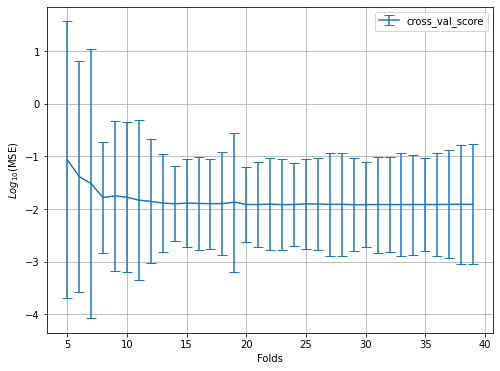

Falta comparar este resultado con Bootstraps


In [8]:

# Defining the degree of our fit 

degree = 5

#Calling our functions and saving the results

X = design_matrix(x,y,z,degree)

#Defining the estimator (The object to use to fit the data)

LinReg = linear_model.LinearRegression()

# scaling the data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Since we still want the first column of the design matrix to be just 1's even after scaling, then

X_scaled[:,0]=1 

#Defining the max number of folds we will evaluate

Fold_max=40

#Defining the vector where we will save the MSE of each cross validation

estimated_mse_sklearn = np.zeros(len(range(5,Fold_max)))
estimated_mse_errors = np.zeros(len(range(5,Fold_max)))
i = 0
for Fld in range(5,Fold_max):
    
    # Initialize a KFold instance
    kfold = KFold(n_splits = Fld)

    
    estimated_mse_folds = cross_val_score(LinReg, X, np.ravel(z), scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    estimated_mse_errors[i] = np.std(-estimated_mse_folds)
    print("For", Fld, "folds, the MSE obtained is: %.4f ± %.4f"% (estimated_mse_sklearn[i],estimated_mse_errors[i]))
    
    i += 1

plt.figure(figsize=(8,6))
plt.errorbar(np.arange(5,Fold_max),np.log10(estimated_mse_sklearn),
             yerr = 1/np.log10(np.e)*(estimated_mse_errors/estimated_mse_sklearn), label='cross_val_score',capsize = 5)

plt.xlabel('Folds')
plt.ylabel('$Log_{10}$(MSE)')

plt.legend()
plt.grid()
#plt.ylim(0,0.85)
plt.show()

print('Falta comparar este resultado con Bootstraps')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


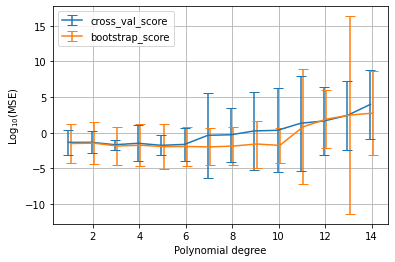

In [9]:
#Since the true MSE is obtained with a large number of folds, we will use from now un a Fold=10

#Ahora vamos a concentrarnos en analizar la dependencia de cross validation y el grado del polinomio
#y luego la dependencia respecto a lambda


maxdegree=15

# Initialize a KFold instance
kfold = KFold(n_splits = 10)

LinReg = linear_model.LinearRegression()

#Defining the vector where we will save the MSE of each cross validation

estimated_mse_sklearn = np.zeros(maxdegree)
estimated_mse_errors = np.zeros(maxdegree)

# Bootstrap errors
error = np.zeros(maxdegree)
error_error = np.zeros(maxdegree)

for degree in range(1,maxdegree):
    
    X = design_matrix(x,y,z,degree)
    #scaling not performed, not sure if this does it before the folds
    #scaler = StandardScaler()
    #scaler.fit(X)
    #X_scaled = scaler.transform(X)

    #X_scaled[:,0]=1 
    
    
    estimated_mse_folds = cross_val_score(LinReg, X, np.ravel(z), scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[degree] = np.mean(-estimated_mse_folds)
    estimated_mse_errors[degree] = np.std(-estimated_mse_folds)
    
    """ Bootstrapping part """
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    # scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #Since we still want the first column of the design matrix to be just 1's even after scaling, then
    X_train_scaled[:,0]=1 
    X_test_scaled[:,0]=1
    
    # The following (80 x n_bootstraps) matrix holds the column vectors z_pred
    # for each bootstrap iteration.  
    z_pred = np.empty((z_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        X_, z_ = resample(X_train_scaled, z_train)
        #Calculating the fit 
        beta = np.linalg.inv(X_.T @ X_) @ X_.T @ z_
        z_pred[:, i] = X_test_scaled@beta 
    error[degree] = np.mean( np.mean((z_test.reshape(z_test.shape[0],1) - z_pred)**2, axis=1, keepdims = True) )
    error_error[degree] = np.std( np.mean((z_test.reshape(z_test.shape[0],1) - z_pred)**2, axis=1, keepdims = True) )
    
plt.errorbar(np.arange(maxdegree)-0.05, np.log10(estimated_mse_sklearn),
             yerr = 1/np.log10(np.e)*(estimated_mse_errors/estimated_mse_sklearn), label='cross_val_score',capsize = 5)
plt.errorbar(np.arange(maxdegree)+0.05, np.log10(error),
             yerr = 1/np.log10(np.e)*(error_error/error), label='bootstrap_score',capsize = 5)
plt.xlabel('Polynomial degree')
plt.ylabel('Log$_{10}$(MSE)')
plt.legend()
plt.grid()
#plt.ylim(0,500)


In [10]:
estimated_mse_errors

array([0.00000000e+00, 3.39100416e-02, 2.94696884e-02, 6.08192345e-03,
       3.53295033e-02, 1.03917246e-02, 2.28650122e-02, 1.10379067e+00,
       8.46463456e-01, 4.15331388e+00, 5.54719194e+00, 6.16956090e+01,
       9.18302529e+01, 5.45475083e+02, 2.01527383e+04])

##Parameter confidence intervals

In [11]:
BS_betas = np.mean(np.array(betas[2]),axis=0)
BS_betas_error = np.std(np.array(betas[2]),axis=0)

(400, 10) 10
10
[0 1 2 3 4 5 6 7 8 9] [ 0.42080753  0.08316164  0.39929663 -0.9446433   0.3414957  -1.87842179
  0.56366478  0.10823666 -0.25982061  1.23233224]


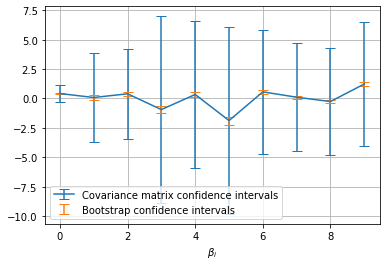

In [12]:

#calculating the intervals of confidence
X = design_matrix(x,y,z,3)
print(X.shape,len(BS_betas))
i=np.arange(len(BS_betas))
print(len(BS_betas))
var = np.diag(np.linalg.inv(X.T @ X))
std = np.sqrt(var)
print(i,BS_betas)
plt.errorbar(i,BS_betas,1.96*std,label='Covariance matrix confidence intervals',capsize = 5)
plt.errorbar(i,BS_betas,1.96*BS_betas_error,fmt = 'none',label='Bootstrap confidence intervals', capsize = 5)
plt.xlabel(r'$\beta_i$')
plt.legend()
plt.grid()


##Ridge regression model

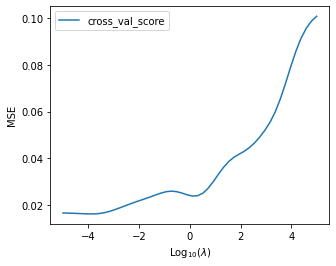

In [13]:
# Defining the degree of our fit 

degree = 5

#Calling our functions and saving the results

X = design_matrix(x,y,z,degree)

# scaling the data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Since we still want the first column of the design matrix to be just 1's even after scaling, then

X_scaled[:,0]=1 

# Decide which values of lambda to use
nlambdas = 50
lambdas = np.logspace(-5, 5, nlambdas)

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k)
estimated_mse_sklearn = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    estimated_mse_folds = cross_val_score(ridge, X_scaled, np.ravel(z), scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    i += 1
    
plt.figure(figsize=(5,4))
plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.xlabel('Log$_{10}(\lambda$)')
plt.ylabel('MSE')
plt.legend()
plt.show()

Remarks: error generally goes down with increasing number of kfold


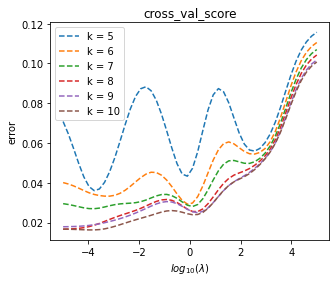

In [14]:
plt.figure(figsize=(5,4))
# same as previously but looped among different k = fold
nlambdas = 50
lambdas = np.logspace(-5, 5, nlambdas)
estimated_mse_sklearn = np.zeros(nlambdas)
krange = [i for i in range(5,11)]
for fold in krange:
  kfold = KFold(n_splits = fold)
  i = 0
  for lmb in lambdas:
      ridge = Ridge(alpha = lmb)
      estimated_mse_folds = cross_val_score(ridge, X_scaled, np.ravel(z), scoring='neg_mean_squared_error', cv=kfold)
      estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
      i += 1
  plt.plot(np.log10(lambdas), estimated_mse_sklearn, '--', label = 'k = {}'.format(fold))

plt.title('cross_val_score')
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('error')
plt.legend()
print('Remarks: error generally goes down with increasing number of kfold')

Lambda value: 1e-10
Lambda value: 2.5595479226995335e-10
Lambda value: 6.551285568595495e-10
Lambda value: 1.67683293681101e-09
Lambda value: 4.291934260128778e-09
Lambda value: 1.0985411419875573e-08
Lambda value: 2.8117686979742307e-08
Lambda value: 7.196856730011529e-08
Lambda value: 1.8420699693267165e-07
Lambda value: 4.7148663634573897e-07
Lambda value: 1.2067926406393288e-06
Lambda value: 3.088843596477485e-06
Lambda value: 7.906043210907702e-06
Lambda value: 2.0235896477251556e-05
Lambda value: 5.1794746792312125e-05
Lambda value: 0.0001325711365590111
Lambda value: 0.000339322177189533
Lambda value: 0.000868511373751352
Lambda value: 0.0022229964825261957
Lambda value: 0.005689866029018305
Lambda value: 0.014563484775012445
Lambda value: 0.03727593720314938
Lambda value: 0.09540954763499963
Lambda value: 0.2442053094548655
Lambda value: 0.6250551925273976
Lambda value: 1.5998587196060574
Lambda value: 4.094915062380419
Lambda value: 10.481131341546874
Lambda value: 26.82695795

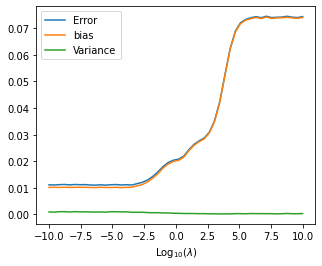

In [15]:
#import sklearn.linear_model as skl

n_boostraps = 100
degree=5

# Make design matrix

z = np.ravel(z)
X = design_matrix(x,y,z,degree)


# Decide which values of lambda to use
nlambdas = 50
lambdas = np.logspace(-10,10, nlambdas)

error = np.zeros(nlambdas)
bias = np.zeros(nlambdas)
variance = np.zeros(nlambdas)
lmbvalue = np.zeros(nlambdas)


#splitting the data

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# scaling the data

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
#Since we still want the first column of the design matrix to be just 1's even after scaling, then
X_train_scaled[:,0]=1 
X_test_scaled[:,0]=1

j=0
for lmb in lambdas:
    # The following matrix holds the column vectors z_pred
    # for each bootstrap iteration.  
    z_pred = np.empty((z_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        X_, z_ = resample(X_train_scaled, z_train)
        #Calculating the fit 
        clf_ridge = Ridge(alpha=lmb).fit(X_, z_)
        z_pred[:, i] = clf_ridge.predict(X_test_scaled)
        
        
# Note: Expectations and variances taken w.r.t. different training
# data sets, hence the axis=1. Subsequent means are taken across the test data
# set in order to obtain a total value, but before this we have error/bias/variance
# calculated per data point in the test set.
# Note 2: The use of keepdims=True is important in the calculation of bias as this 
# maintains the column vector form. Dropping this yields very unexpected results.
    lmbvalue[j] = lmb
    error[j] = np.mean( np.mean((z_test.reshape(z_test.shape[0],1) - z_pred)**2, axis=1, keepdims=True) )
    bias[j] = np.mean( (z_test.reshape(z_test.shape[0],1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[j] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    print('Lambda value:', lmb)
    #print('Error:', error[j])
    #print('Bias^2:', bias[j])
    #print('Var:', variance[j])
    #print('{} >= {} + {} = {}'.format(error[j], bias[j], variance[j], bias[j]+variance[j]))
    j+=1

plt.figure(figsize=(5,4))
plt.plot(np.log10(lmbvalue), error, label='Error')
plt.plot(np.log10(lmbvalue), bias, label='bias')
plt.plot(np.log10(lmbvalue), variance, label='Variance')
plt.xlabel('Log$_{10}(\lambda$)')
plt.legend()
plt.show()



# Boston housing  data example

The Boston housing  
data set was originally a part of UCI Machine Learning Repository
and has been removed now. The data set is now included in **Scikit-Learn**'s 
library.  There are 506 samples and 13 feature (predictor) variables
in this data set. The objective is to predict the value of prices of
the house using the features (predictors) listed here.

The features/predictors are
1. CRIM: Per capita crime rate by town

2. ZN: Proportion of residential land zoned for lots over 25000 square feet

3. INDUS: Proportion of non-retail business acres per town

4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

5. NOX: Nitric oxide concentration (parts per 10 million)

6. RM: Average number of rooms per dwelling

7. AGE: Proportion of owner-occupied units built prior to 1940

8. DIS: Weighted distances to five Boston employment centers

9. RAD: Index of accessibility to radial highways

10. TAX: Full-value property tax rate per USD10000

11. B: $1000(Bk - 0.63)^2$, where $Bk$ is the proportion of [people of African American descent] by town

12. LSTAT: Percentage of lower status of the population

13. MEDV: Median value of owner-occupied homes in USD 1000s

In [16]:
import pandas as pd
from sklearn.datasets import load_boston

boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target
print(boston_df)

        CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  MEDV
0    0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98  24.0
1    0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14  21.6
2    0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03  34.7
3    0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94  33.4
4    0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33  36.2
..       ...   ...    ...   ...    ...  ...    ...      ...     ...    ...   ...
501  0.06263   0.0  11.93   0.0  0.573  ...  273.0     21.0  391.99   9.67  22.4
502  0.04527   0.0  11.93   0.0  0.573  ...  273.0     21.0  396.90   9.08  20.6
503  0.06076   0.0  11.93   0.0  0.573  ...  273.0     21.0  396.90   5.64  23.9
504  0.10959   0.0  11.93   0.0  0.573  ...  273.0     21.0  393.45   6.48  22.0
505  0.04741   0.0  11.93   0.0  0.573  ...  273.0     21.0  396.90   7.88  11.9

[506 rows x 14 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


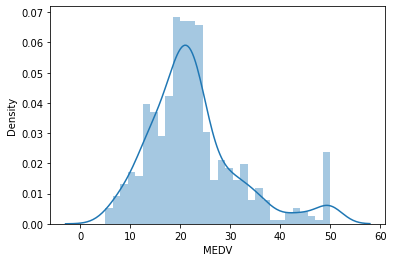

In [17]:
# plot a histogram showing the distribution of the target values
sns.distplot(boston_df['MEDV'], bins=30)
plt.show()

#The median is concentrated around 20,000 USD roughly

##Feature selection

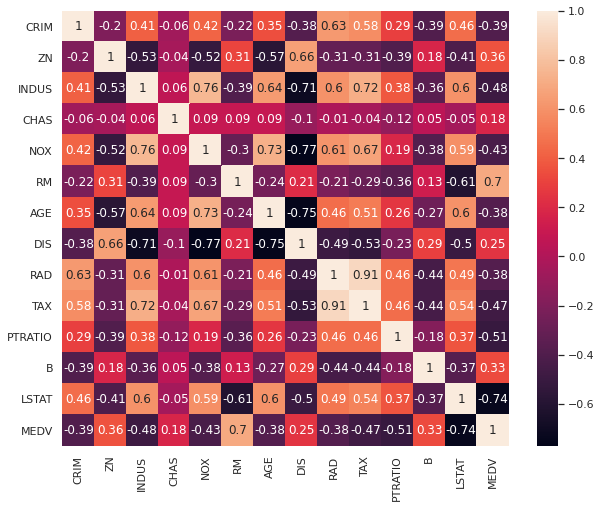

In [18]:
# set the size of the figure
sns.set(rc={'figure.figsize':(10,8)})

# compute the pair wise correlation for all columns  
correlation_matrix = boston_df.corr().round(2)

# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

From the above coorelation plot we can see that **MEDV** is strongly correlated to **LSTAT** (low income and education) and  **RM** (number of rooms). We see also that **RAD** and **TAX** are stronly correlated, but we don't include this in our features together to avoid multi-colinearity 

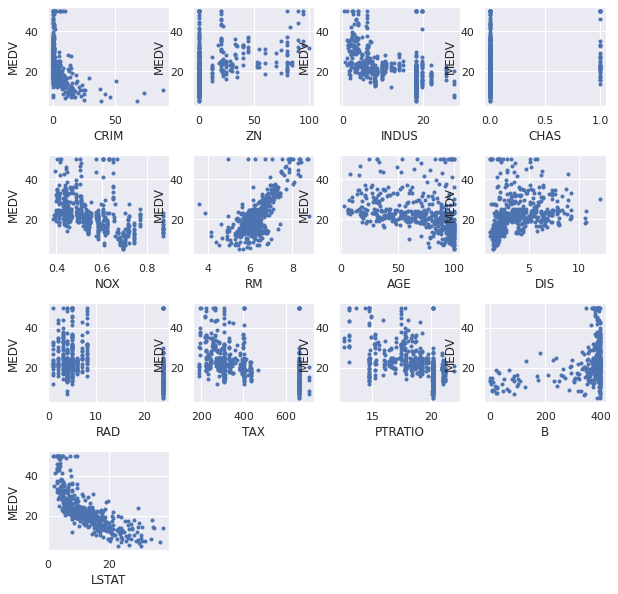

In [19]:
plt.figure(figsize=(10, 10))

features = boston_data.feature_names#['LSTAT', 'RM']
target = boston_df['MEDV']

for i, col in enumerate(features):
    plt.subplot(4, int(np.ceil(len(features)/4)) , i+1)
    x = boston_df[col]
    y = target
    plt.scatter(x, y, marker='.')
    plt.xlabel(col)  
    plt.ylabel('MEDV')
    plt.subplots_adjust(hspace=.5)

We see that LSTAT and RM are the most natural candidates. We'll include those and also NOX and DIS.

In [20]:
features = ['LSTAT', 'RM','NOX','DIS']

##Simple linear fit

In [21]:
X = pd.DataFrame(np.array([boston_df[k] for k in features]).T, columns = features)
Y = boston_df['MEDV']

# splits the training and test data set in 80% : 20%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 4)
(102, 4)
(404,)
(102,)


Let's start with a simple linear regression

In [22]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

# model evaluation for training set

y_train_predict = lin_model.predict(X_train)
mse = mean_squared_error(Y_train, y_train_predict)
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set

y_test_predict = lin_model.predict(X_test)
# root mean square error of the model
mse = mean_squared_error(Y_test, y_test_predict)

# r-squared score of the model
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))


The model performance for training set
--------------------------------------
MSE is 30.258754433549328
R2 score is 0.6477513798821646


The model performance for testing set
--------------------------------------
MSE is 23.87681992670406
R2 score is 0.6950358907813283


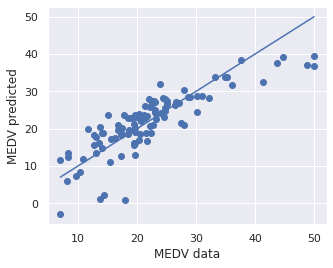

In [23]:
# plotting the y_test vs y_pred
# ideally should have been a straight line
plt.figure(figsize=(5,4))
plt.scatter(Y_test, y_test_predict)
plt.ylabel('MEDV predicted')
plt.xlabel('MEDV data')
z = np.linspace(min(Y_test),max(Y_test))
plt.plot(z,z)
plt.show()

We can conclude that the straight regression line is unable to capture the patterns in the data. This is an example of underfitting. To overcome underfitting, we need to increase the complexity of the model. This could be done by converting the original features into their higher order polynomial terms by using the PolynomialFeatures class provided by scikit-learn. Next, we train the model using Linear Regression.

Now let's analyze the dependence of the MSE with respect of the polinomial degree of our fit

##Bias-variance trade-off with OLS

Polynomial degree: 1 with an MSE: 24.44698814224548
Polynomial degree: 2 with an MSE: 15.574043112751013
Polynomial degree: 3 with an MSE: 16.30313805464384
Polynomial degree: 4 with an MSE: 74.40284658057153


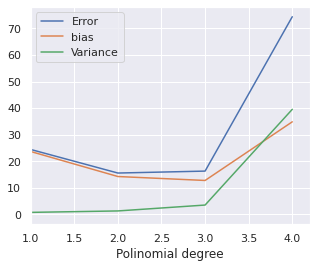

In [24]:
from sklearn.pipeline import make_pipeline

n_boostraps = 100
maxdegree = 5


error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)


for degree in range(1,maxdegree):
    
    # scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #Model use to fit
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    # The following (80 x n_bootstraps) matrix holds the column vectors z_pred
    # for each bootstrap iteration.  
    Y_pred = np.empty((Y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        X_, Y_ = resample(X_train_scaled, Y_train)
        #Calculating the fit 
        Y_pred[:, i] = model.fit(X_, Y_).predict(X_test_scaled).ravel()
        
# Note: Expectations and variances taken w.r.t. different training
# data sets, hence the axis=1. Subsequent means are taken across the test data
# set in order to obtain a total value, but before this we have error/bias/variance
# calculated per data point in the test set.
# Note 2: The use of keepdims=True is important in the calculation of bias as this 
# maintains the column vector form. Dropping this yields very unexpected results.
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((Y_test.values.reshape(Y_test.shape[0],1) - Y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (Y_test.values.reshape(Y_test.shape[0],1) - np.mean(Y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(Y_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree, "with an MSE:", error[degree])
    
plt.figure(figsize=(5,4))
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Polinomial degree')
plt.xlim(xmin=1)
plt.legend()
plt.show()

Polynomial degree: 1  Test error: 38.17594653399894 ± 35.89939036806428
Polynomial degree: 2  Test error: 25.97749434333832 ± 26.41082783121452
Polynomial degree: 3  Test error: 22.54376486767371 ± 20.561227912848967
Polynomial degree: 4  Test error: 130.52877522136927 ± 170.23014633761073
Polynomial degree: 5  Test error: 2900.6660180060126 ± 6217.208692311078
Polynomial degree: 6  Test error: 154242.14062786067 ± 405425.7101312695
Polynomial degree: 7  Test error: 2473581.930970858 ± 3220235.9798087287


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


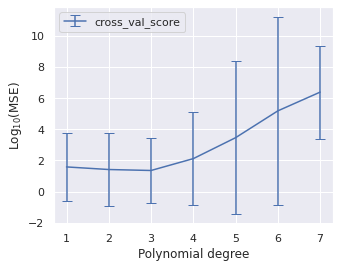

In [25]:
from sklearn.pipeline import Pipeline

#Ahora vamos a concentrarnos en analizar la dependencia de cross validation y el grado del polinomio
X = pd.DataFrame(np.array([boston_df[k] for k in features]).T, columns = features)
Y = boston_df['MEDV']

maxdegree=8

# Initialize a KFold instance
kfold = KFold(n_splits = 10)

LinReg = linear_model.LinearRegression()

#Defining the vector where we will save the MSE of each cross validation

estimated_mse_sklearn = np.zeros(maxdegree)
estimated_mse_errors = np.zeros(maxdegree)

# scaling the data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#It is always a good idea to seperate the test set and training set, 
#even while using cross_val_score. The reason behind this is knowledge leaking. 
#It basically means that when you use both training and test sets, you are leaking information 
#from test set into your model, thereby making your model biased, leading to incorrect predictions.

for degree in range(1,maxdegree):

    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_scaled, Y)
    
    estimated_mse_folds = cross_val_score(pipeline, X_scaled,Y, scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[degree] = np.mean(-estimated_mse_folds)
    estimated_mse_errors[degree] = np.std(-estimated_mse_folds)

    print('Polynomial degree:', degree," Test error: {} ± {}".format(np.mean(-estimated_mse_folds),np.std(-estimated_mse_folds)))
    
#plt.plot(np.arange(maxdegree), np.log10(estimated_mse_sklearn), label='cross_val_score')
plt.figure(figsize=(5,4))
plt.errorbar(np.arange(maxdegree),np.log10(estimated_mse_sklearn),
             yerr = 1/np.log10(np.e)*(estimated_mse_errors/estimated_mse_sklearn), label='cross_val_score',capsize = 5)
plt.xlabel('Polynomial degree')
plt.ylabel('Log$_{10}$(MSE)')
plt.legend()
plt.show()

##Search for optimal parameters

The best fit is given by a polinomial of degree 3. Let's now analyze the MSE dependence on the $\lambda$ parameter for a Ridge regression.

In [26]:
features

['LSTAT', 'RM', 'NOX', 'DIS']

The minimum error found among all was 21.785138415365573 ± 24.52336727466679 with a degree 2 and lambda 2.559547922699533


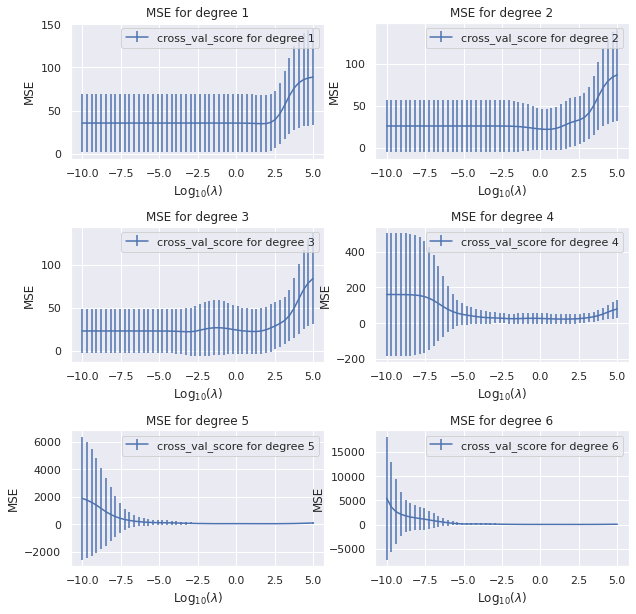

In [27]:
X = pd.DataFrame(np.array([boston_df[k] for k in features]).T, columns = features)
Y = boston_df['MEDV']

# Decide degree on polynomial to fit and create the design matrix
plt.figure(figsize=(10, 10))
nlambdas = 50
maxdegree = 7
min_error = 1000

for d in range(1,maxdegree):
    plt.subplot(3, int(np.ceil((maxdegree-1)/3)) , d)
    poly = PolynomialFeatures(degree = d)
    X_design = poly.fit_transform(X)

    # scaling the data
    scaler = StandardScaler()
    scaler.fit(X_design)
    X_design_scaled = scaler.transform(X_design)
    X_design_scaled[:,0]=1 


    # Decide which values of lambda to use
    
    lambdas = np.logspace(-10, 5, nlambdas)

    # Initialize a KFold instance
    k = 15
    kfold = KFold(n_splits = k)
    estimated_mse_sklearn = np.zeros(nlambdas)
    estimated_mse_error = np.zeros(nlambdas)
    
    i = 0
    for lmb in lambdas:
        ridge = Ridge(alpha = lmb)
        estimated_mse_folds = cross_val_score(ridge,
                                              X_design_scaled, Y, scoring='neg_mean_squared_error', cv=kfold)
        estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
        #print(estimated_mse_error.shape,i)
        estimated_mse_error[i] = np.std(-estimated_mse_folds)
        #print('For a lambda value of',lmb,' the MSE is: ',estimated_mse_sklearn[i] )
        i += 1
    
    min_error_lambda = min(estimated_mse_sklearn)
    lambopt = list(lambdas)[list(estimated_mse_sklearn).index(min_error_lambda)]
    min_error_error = list(estimated_mse_error)[list(estimated_mse_sklearn).index(min_error_lambda)]
    if min_error_lambda < min_error:
        min_error = min_error_lambda
        best_errorerror = min_error_error
        best_degree = d
        best_lambopt = lambopt
    #print('Polynomial degree:', d)
    #print(np.mean(estimated_mse_error))
    
    plt.errorbar(np.log10(lambdas), estimated_mse_sklearn,
                 yerr=estimated_mse_error, label = 'cross_val_score for degree {}'.format(d))
    plt.xlabel('Log$_{10}(\lambda$)')
    plt.ylabel('MSE')
    plt.subplots_adjust(hspace=.5)
    plt.legend()
    plt.title('MSE for degree {}'.format(d))
    #plt.show()
#figure.tight_layout(pad=3.0)
print("The minimum error found among all was {} ± {} with a degree {} and lambda {}".format(min_error,
                                                                                            best_errorerror,
                                                                                            best_degree,
                                                                                            best_lambopt))

Most models, except for the ones of degree 1 and 3, find a local minimum for lambda. In the case of the ones of higher degree than 3, we can suspect that the shrinkage does away with unwanted overfitting. We've found the best score for the model with a fit of degree 2, right on a local minimum that's deeper than any of the ones for degree 3 or 1.

##Predicted MEDV values from the final model

The performance for the test set with the OLS model
--------------------------------------
Mean squared error: 18.676861307333123 ± 19.613719255982506
Variance score: 0.773783245583221 ± 0.21721461629824904

The performance for the test set with the Ridge model
--------------------------------------
Mean squared error: 17.740153092279364 ± 18.409730516196866
Variance score: 0.788093347115125 ± 0.18575811149990495


Text(0.5, 0, 'MEDV data')

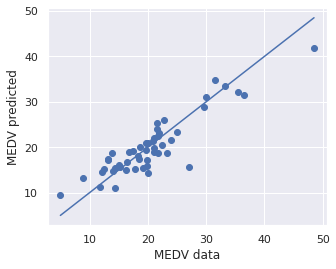

In [28]:
lmb=best_lambopt

# Decide degree on polynomial to fit and create the design matrix
X = pd.DataFrame(np.array([boston_df[k] for k in features]).T, columns = features)
Y = boston_df['MEDV']

# Pasos 1 y 2 ocurren en la siguiente línea
n_k = 10
kfold = KFold(n_k,True,1)
# Paso 3 ocurre al usar split
splitdata = kfold.split(X = X, y = Y)
mse = np.zeros((2,n_k)) # Aquí es donde guardaré mi medida de varianza para cada modelo
r2 = np.zeros((2,n_k)) # It's 2 because it's two different models we're saving
count = 0
for train, test in splitdata:
    X_train, X_test, Y_train, Y_test = X.iloc[train], X.iloc[test], Y.iloc[train], Y.iloc[test]
    poly = PolynomialFeatures(degree = best_degree)
    Xtest_design = poly.fit_transform(X_test)
    Xtrain_design = poly.fit_transform(X_train)

    # scaling the data
    scaler = StandardScaler()
    scaler.fit(Xtest_design)
    Xtest_scaled = scaler.transform(Xtest_design)
    Xtrain_scaled = scaler.transform(Xtrain_design)
    Xtest_scaled[:,0] = 1 
    Xtrain_scaled[:,0] = 1 


    #Models use to fit
    OLS = LinearRegression()
    ridge = Ridge(alpha = lmb)


    # model evaluation for training set

    ridge.fit(Xtrain_scaled, Y_train)
    OLS.fit(Xtrain_scaled, Y_train)


    # We use now Scikit-Learn's linear regressor and ridge regressor
    # OLS part
    ypred_OLS = OLS.predict(Xtest_scaled)
    mse[0,count] = mean_squared_error(Y_test, ypred_OLS)
    r2[0,count] = r2_score(Y_test, ypred_OLS)
    # The Ridge regression 
    ypred_ridge = ridge.predict(Xtest_scaled)
    mse[1,count] = mean_squared_error(Y_test, ypred_ridge)
    r2[1,count] = r2_score(Y_test, ypred_ridge)
    
    count += 1

print("The performance for the test set with the OLS model")
print("--------------------------------------")
print("Mean squared error: {} ± {}".format(np.mean(mse[0]),2*np.std(mse[0])))
print('Variance score: {} ± {}'.format(np.mean(r2[0]),2*np.std(r2[0])))




print('\b')
print("The performance for the test set with the Ridge model")
print("--------------------------------------")
print("Mean squared error: {} ± {}".format(np.mean(mse[1]),2*np.std(mse[1])))
print('Variance score: {} ± {}'.format(np.mean(r2[1]),2*np.std(r2[1])))



plt.figure(figsize=(5,4))

plt.scatter(Y_test, ypred_ridge)
z = np.linspace(min(Y_test),max(Y_test))
plt.plot(z,z)
plt.ylabel('MEDV predicted')
plt.xlabel('MEDV data')
#plt.show()

The results are shown with 2 sigma confidence intervals, under which we can't say that Ridge shrinkage shows an improvement over OLS, but it does seem to point to an improvement????